# Email Analysis
- Look at top senders
- Predict email volume by day: arima, bayesian, holt winters, lstm

In [15]:
#initialize
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#screen width
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 4

# from IPython.core.display import HTML
# HTML("<style>.container{ width: 95% !important; }</style>")

import datetime

# Download headers

In [24]:
import imaplib, email
from email.parser import HeaderParser
import dateutil
import getpass

print('gmail:')
email = getpass.getpass()
print('pw:')
pw = getpass.getpass()

gmail:
········
pw:
········


In [ ]:
#download
server = imaplib.IMAP4_SSL('imap.gmail.com')
server.login(email,pw)
server.select(readonly=1)
(retcode, messages) = server.search(None, '(UNSEEN)')

fromDt = datetime.date.today() + datetime.timedelta(days=-10)
# print('getting emails back to {}'.format(fromDt))

typ, data = server.search(None, 'ALL')
hdrs = []
for num in reversed(data[0].split()):   
    typ2, data2 = server.fetch(num, '(BODY.PEEK[HEADER])')
    msg = email.message_from_bytes(data2[0][1])
    parser = HeaderParser()
    h = parser.parsestr(msg.as_string())
    if dateutil.parser.parse(h.get('Date')).date() < fromDt:
        break
    hdrs.append([num,h.get('From')
                ,h.get('Date')
                ,h.get('Subject')]
               )
    
df = pd.DataFrame(hdrs)
df.columns = ['Num','From','Received','Subject']
# df.to_csv('data/email.csv',index=False)
# df.head()

In [2]:
# import data.  data is from another script i wrote scraping my email headers
df = pd.read_csv('data/email.csv',parse_dates=['Received'])
df['Received'] = pd.to_datetime([datetime.datetime.strftime(r.Received,'%Y-%m-%d') for r in df.itertuples()])
df.set_index('Received',inplace=True)
df.head(2)

/home/nathan/anaconda3/lib/python3.6/site-packages/dateutil/parser/_parser.py:1206: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/nathan/anaconda3/lib/python3.6/site-packages/dateutil/parser/_parser.py:1206: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


,NumEmails,Sender
Received,,
2017-05-19,1,"""Nextdoor Cool Springs East"" <no-reply@rs.emai..."
2017-05-19,1,"""Nextdoor Cool Springs East"" <reply@rs.email.n..."


# Analyze by day, month, dow

In [3]:
# import warnings
# warnings.filterwarnings("ignore")

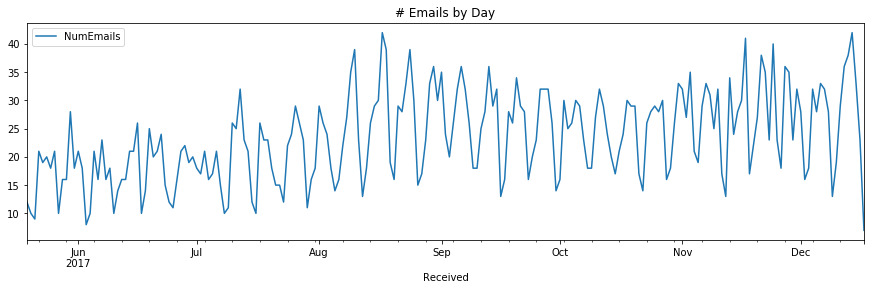

In [16]:
byDay = df.resample('D')['NumEmails'].sum().to_frame()
byDay.plot(title='# Emails by Day');

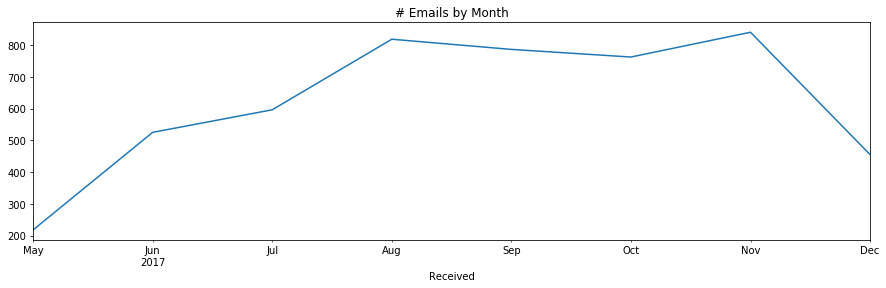

In [17]:
_=df.resample('M')['NumEmails'].sum().plot(title='# Emails by Month')

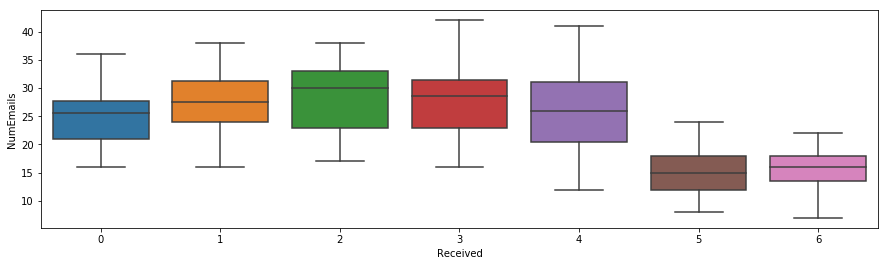

In [18]:
import seaborn as sns
sns.boxplot(byDay.index.weekday,byDay.NumEmails);

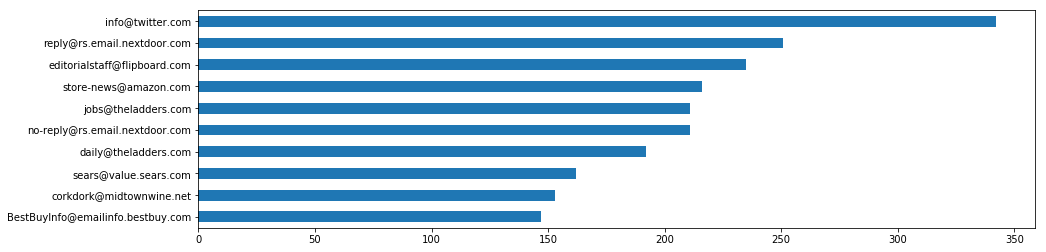

In [19]:
#who's sending me too many emails?

#parse sendername between <>
df['SenderName'] = df.Sender.apply(lambda s: s[s.find('<') + 1 : s.find('>')])
df['SenderName'].value_counts()[:10].plot(kind='barh').invert_yaxis();

# Test Train

In [8]:
cutoff = int(byDay.size * .85) 
train = byDay[:cutoff].values
test = byDay[cutoff:].values

In [26]:
#arima

# lag of 0, by definition, is perfectly correlated (@ 1) to its own values
# look for max lag value > 0 that statistically significant (above dotted threshold) 
# that will give us parameter p

# from pandas.plotting import autocorrelation_plot
# plt.figure(figsize=(15,4))
# autocorrelation_plot(byDay);

# from statsmodels.tsa.stattools import adfuller

## consider box cox?

from pmdarima.arima import auto_arima
m = auto_arima(train,seasonal=True, m=12, error_action='ignore')#, trace=1)
arima = m.predict(n_periods=test.shape[0])

/home/nathan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/nathan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/nathan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for m

In [10]:
#holt winters

/home/nathan/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nathan/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


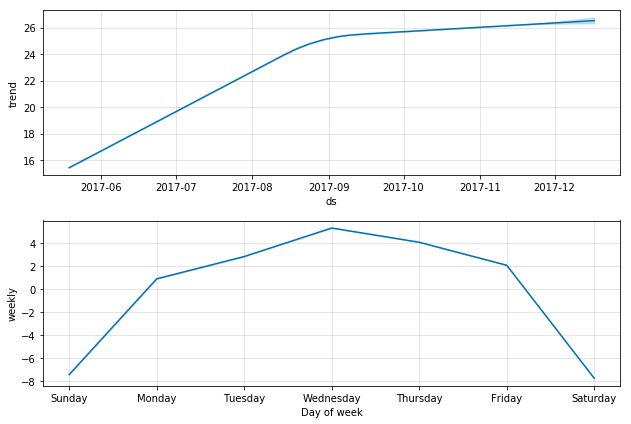

In [27]:
#facebook (bayesian inference)
from fbprophet import Prophet
m = Prophet()
m.fit(byDay[:cutoff].reset_index().rename(columns={'Received':'ds','NumEmails':'y'}))
future = m.make_future_dataframe(periods=test.size)
forecast = m.predict(future)
# fig1 = m.plot(forecast);
fig1 = m.plot_components(forecast)
fb = forecast.tail(test.size)['yhat'].values

In [ ]:
## add lstm keras

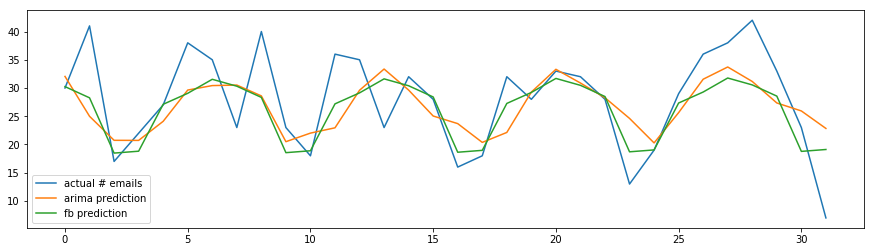

In [21]:
fig, ax = plt.subplots()
ax.plot(test,label='actual # emails');
ax.plot(arima,label='arima prediction');
ax.plot(fb,label='fb prediction');
ax.legend();

In [14]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

'arima rmse = {:.2f}'.format(rmse(test,arima))
'fb rmse = {:.2f}'.format(rmse(test,fb))

'arima rmse = 9.71'

'fb rmse = 10.19'